<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo03_analise_exploracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise e explocação do dataset

### Iniciando pela configuração do Google Colab

In [ ]:
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 5.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
# Configura acesso ao Google Driver onde serão salvos os arquivos grandes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importação de bibliotecas utilizadas no pré-processamento
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pt_core_news_sm
from IPython.display import display
%matplotlib inline
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 250)

### Carregar arquivo CSV das bases unificadas e validar

In [ ]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/dataset_tratado.csv', sep = ',', names=['classe', 'texto', 'qtde_palavras', 'texto_processado'], header=1).reset_index(drop=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8063 entries, 0 to 8062
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   classe            8063 non-null   int64 
 1   texto             8063 non-null   object
 2   qtde_palavras     8063 non-null   int64 
 3   texto_processado  8063 non-null   object
dtypes: int64(2), object(2)
memory usage: 252.1+ KB


## Limpeza básica para exploração usando lib Spacy
Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto) 

Para o modelo final serão feitos testes com e sem lematizar, bem como a pontuação é importante

In [ ]:
nlp = pt_core_news_sm.load()
# Remover stopwords, pontuação e lematizar as setenças
dados["texto_lema_sem_stopwords"] = dados.texto_limpo.apply(
    lambda texto: " ".join([token.lemma_ for token in nlp(texto) 
      if not token.is_stop and
        not token.is_punct]))

### Método auxiliar para simplificar geração de listas de palavras

In [ ]:
def gera_nuvens_palavras(serie_confiavel, serie_falsa):
  # Une todas linhas da série em um único super texto
  texto_confiavel = re.sub(' +', ' ', ' '.join(serie_confiavel))
  texto_falso = re.sub(' +', ' ', ' '.join(serie_falsa))

  # Monta contagem de frequencia das 100 palavras mais comuns 
  contagem_confiavel = Counter(texto_confiavel.split()).most_common(100)
  contagem_falsa = Counter(texto_falso.split()).most_common(100)

  # Monta lista somente com as palavras unicas
  lista_confiavel = [palavra[0] for palavra in contagem_confiavel]
  lista_falsa = [palavra[0] for palavra in contagem_falsa]

  # Monta lista somente com as palavras unicas
  palavras_confiavel = ' '.join([palavra for palavra in re.split("\W+", texto_confiavel) 
      if palavra.lower() in (confiavel.lower() for confiavel in lista_confiavel)])
  palavras_falsas = ' '.join([palavra for palavra in re.split("\W+", texto_falso) 
      if palavra.lower() in (falsa.lower() for falsa in lista_falsa)])
  
  return palavras_confiavel, palavras_falsas

### Método auxiliar para plotar núvens lado a lado

In [ ]:
def plota_nuvens(listaLeft, listaRight, tituloLeft, tituloRight):
  wcLeft = WordCloud(background_color='black', width=800, height=600)
  nuvemLeft = wcLeft.generate(listaLeft)
  wcRight = WordCloud(background_color='black', width=800, height=600)
  nuvemRight = wcRight.generate(listaRight)

  # Plots núvens lado a lado para comparar
  plt.figure(figsize=(18,25))
  f, plots = plt.subplots(nrows=1, ncols=2, figsize=(25, 50))
  plots[0].imshow(nuvemLeft)
  plots[0].set_title(f'Nuvem das Amostras: {tituloLeft}')
  plots[1].imshow(nuvemRight)
  plots[1].set_title(f'Nuvem das Amostras: {tituloRight}')
  plt.show()

### Remove pontuação, stopwords e lematiza conteúdo para as núvens

In [ ]:
nlp = pt_core_news_sm.load()
# Remover stopwords, pontuação e lematizar as setenças
dados["texto_wordcloud"] = dados.texto_processado.apply(
    lambda texto: " ".join([token.lemma_ for token in nlp(texto) 
      if not token.is_stop and not token.is_punct]))

### Gerando nova nuvem de palavras com as 100 mais frequentes

<Figure size 1296x1800 with 0 Axes>

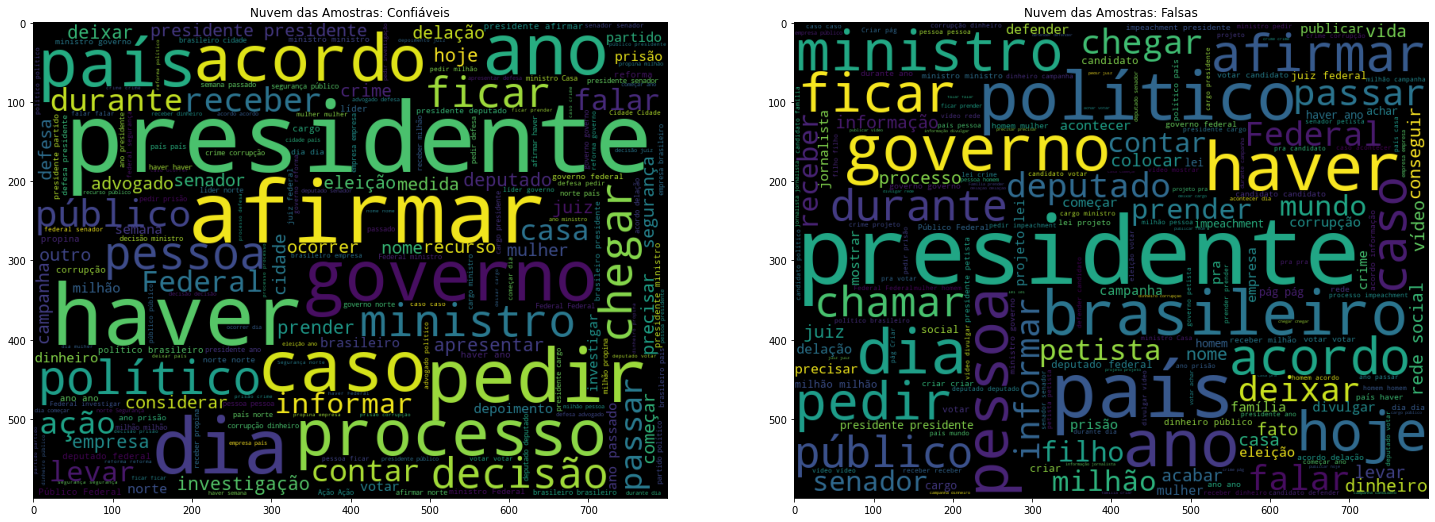

In [ ]:
palavras_confiavel, palavras_falsas = gera_nuvens_palavras(
    dados[dados['classe']==0]['texto_wordcloud'], 
    dados[dados['classe']==1]['texto_wordcloud']
)
plota_nuvens(
    palavras_confiavel, palavras_falsas, 'Confiáveis', 'Falsas'
)

In [ ]:
# Confere lista mais manualmente
' '.join(palavras_confiavel.split())[:1000]

'dinheiro afirmar campanha Defesa investigação milhão dinheiro senador campanha dinheiro ministro afirmar levar casa dinheiro contar ministro campanha s afirmar campanha governo eleição ano campanha político Governo presidente prender milhão deixar campanha senador prender Federal juiz senador País recurso juiz crime 2 Federal político recurso público dinheiro país corrupção investigar dinheiro ano governo político senador político contar campanha investigar contar presidente senador acordo Público investigar caso Público Ação ação dia pedir informar s ação levar público político ano receber Público ano pedir acordo Público dia dia haver ação pessoa dia 1 informar s juiz haver líder semana processo político ano governo s durante ano líder público haver país reforma governo presidente começar eleição presidente país ano ano governo cargo Partido chegar ano haver público receber líder dia dia cidade público s dinheiro chegar chegar s governo semana passado Federal chegar Norte prender pr

### Conferindo as N-gramas do texto para ver como as palavras se relacionam

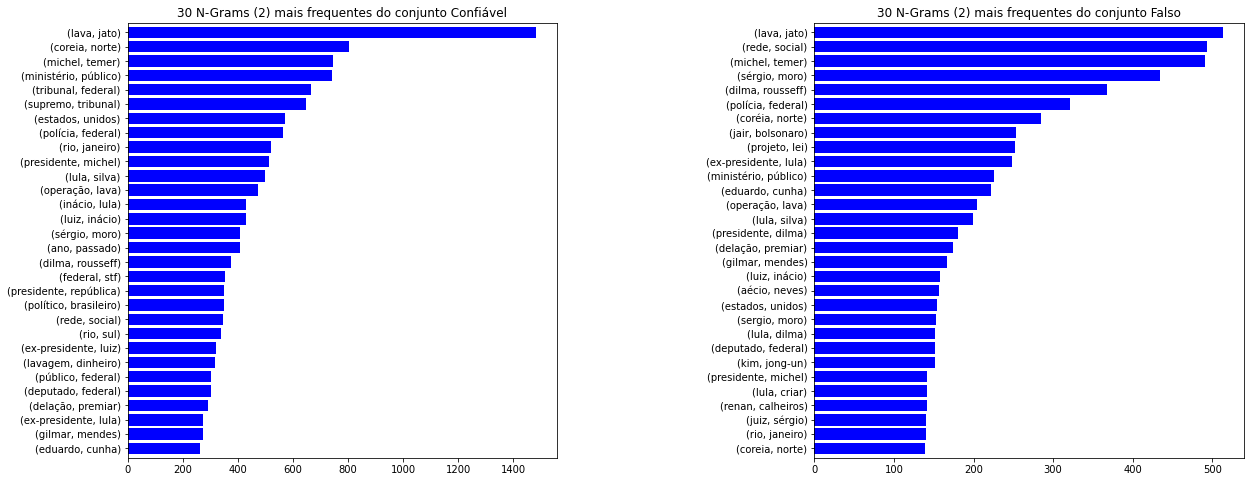

In [ ]:
lista_confiavel = ' '.join(dados[dados['classe']==0]['texto_wordcloud'].str.lower().to_list()).split()
lista_falsa = ' '.join(dados[dados['classe']==1]['texto_wordcloud'].str.lower().to_list()).split()

def exibir_ngrams(lista_confiavel, lista_falsa, n=2, top=30):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  plt.subplots_adjust(wspace=0.6)
  serie_plot = (pd.Series(nltk.ngrams(lista_confiavel, n)).value_counts())[:top]
  serie_plot.sort_values().plot.barh(color='blue', width=.8, ax=axes[0], title=f'{top} N-Grams ({n}) mais frequentes do conjunto Confiável', figsize=(20, 8))
  serie_plot = (pd.Series(nltk.ngrams(lista_falsa, n)).value_counts())[:top]
  serie_plot.sort_values().plot.barh(color='blue', width=.8, ax=axes[1], title=f'{top} N-Grams ({n}) mais frequentes do conjunto Falso', figsize=(20, 8))

exibir_ngrams(lista_confiavel, lista_falsa)    

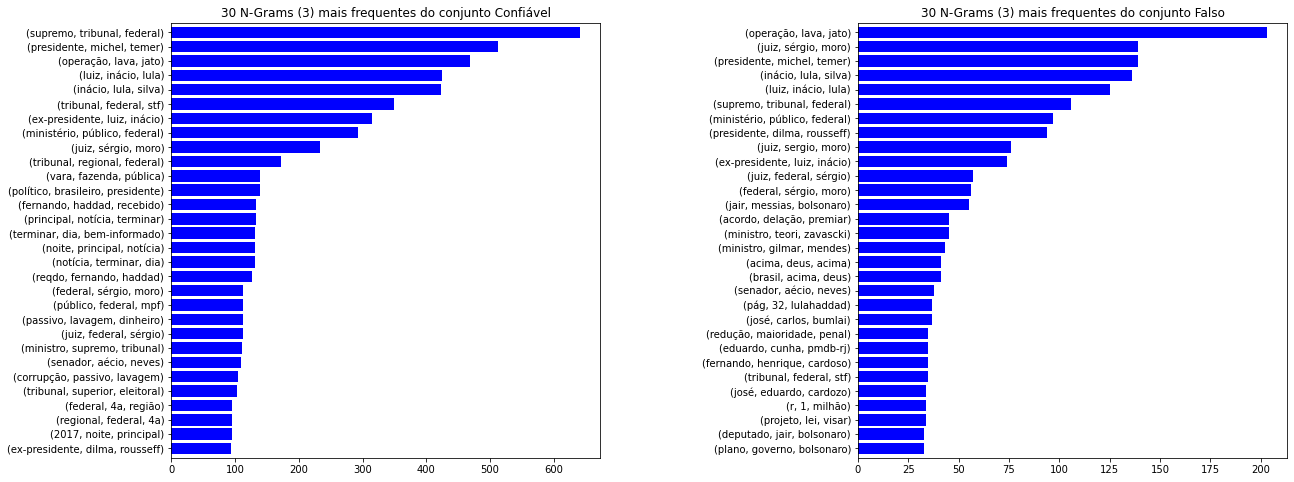

In [ ]:
exibir_ngrams(lista_confiavel, lista_falsa, n=3)

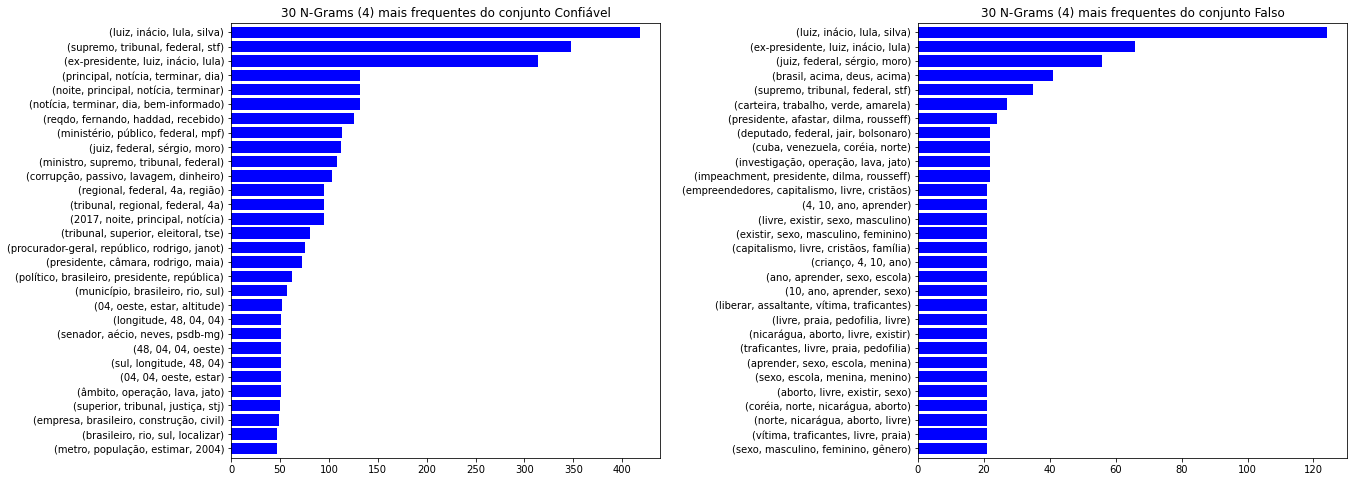

In [ ]:
exibir_ngrams(lista_confiavel, lista_falsa, n=4)

### Gerando word cloud removendo verbos, números e letras soltas além das stopwords e pontuação

In [ ]:
dados["texto_wordcloud_revisao"] = dados.texto_processado.apply(
    lambda texto: " ".join([token.lemma_ for token in nlp(texto) 
      if not token.is_stop and 
        not token.is_punct and
        not token.pos_ in ['VERB', 'AUX', 'NUM'] and 
        len(token.lemma_) > 1]))

KeyboardInterrupt: ignored

<Figure size 1296x1800 with 0 Axes>

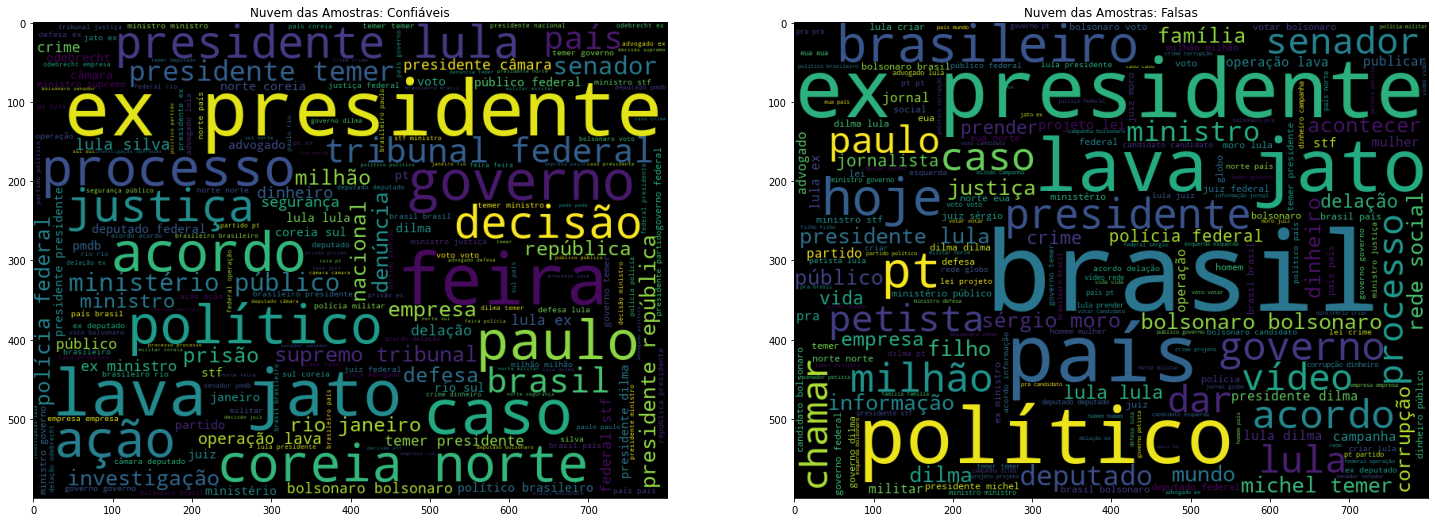

In [ ]:
palavras_confiavel, palavras_falsas = gera_nuvens_palavras(
    dados[dados['classe']==0]['texto_wordcloud_revisao'], 
    dados[dados['classe']==1]['texto_wordcloud_revisao']
)
plota_nuvens(
    palavras_confiavel, palavras_falsas, 'Confiáveis', 'Falsas'
)

In [ ]:
# Salva dados para uso no notebook do próximo passo.
dados.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_tratado.csv', sep = ',', index=False)